# 简介
Kaggle 泰坦尼克 Tutorial。
参考 [Titanic Data Science Solutions](http://localhost:8888/notebooks/Kaggle%20Titanic.ipynb)。

# Workflow Stage

根据《Data Science Solutions》，完整的解答工作流程包含七个阶段：

- 问题或课题定义
- 获取训练及测试样例集
- 整理、预处理、清洗数据
- 分析、识别模式、探索数据
- 建模、预测、解决问题
- 可视化、汇报、呈现问题解决步骤和最终解决方案
- 提供或提交结果

上述工作流指出了通用的步骤顺序。但是，有时候会有些例外。

- 可以结合多个步骤在一起。我们可能通过可视化数据来分析它们。
- 将一些步骤提前。我们可能在数据wrangling之前和之后进行分析数据。
- 重复一些步骤多次。比如，可视化步骤可能使用多次。
- 有时候可能抛弃一些步骤。

# Question and problem definition

像Kaggle之类的竞赛平台，常常在给出问题的同时，给出数据集来训练和测试你的数据科学模型。

这里是Titanic Survival问题的定义：

> Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

# Workflow goals

数据科学解决方案流程通常有七个主要目标：

- 分类（Classifying）
- 关联（Correlating）
- 转换（Converting）
- Completing
- Correcting
- Creating
- Charting

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Acquire data

使用 Pandas 处理数据集。我们首先将训练和测试数据集导入Pandas DataFrames。

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
combine = [train_df, test_df]

# 通过描述数据进行分析

在工程的早期，Pandas 也可以帮助描述数据集来解答下面的问题。

## 哪些数据集属性是可用的?

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## 那些特征是可分类的?
这些值将样本分为相似的几组。这些可分类特征，属于名词(nominal), 序数词(ordinal), 比率(ratio), 还是间隔(interval)？。除此之外，这有助于我们选择合适的图表进行可视化。

- Categorical: Survived, Sex, and Embarked
- Ordinal: Pclass

## 哪些特征是数字的？
这些值随着样品的不同而不同。数值特征中的值是基于离散，连续，还是时间序列？

- Continous: Age, Fare
- Discrete: SibSp, Parch

In [4]:
# preview the data
print(train_df.head())
print(train_df.tail())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

## 哪些特征包含空值或者null ？
这些值需要修正。
- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age > Fare are incomplete in case of test dataset

## 每个特征的数据类型是什么？
在目标转换时会有用。
- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

In [5]:
train_df.info()
print('_ _ ' * 10)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## 样本中数值特征值的分布是什么？
这有助于我们，在得出其他结论之前，判断训练数据对实际问题的代表性如何。

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_df.describe(percentiles=[.75, .8])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
80%,713.000000,1.000000,3.000000,41.000000,1.000000,1.000000,39.687500
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train_df.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,90.000000,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
20%,179.000000,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
30%,268.000000,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
40%,357.000000,0.000000,2.000000,25.000000,0.000000,0.000000,10.500000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,535.000000,0.000000,3.000000,31.800000,0.000000,0.000000,21.679200


## 分类特征的分布是什么？
- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Markun, Mr. Johann",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


# 基于数据分析作出假设
我们根据到目前为止所做的数据分析得出以下假设。我们可能会在采取适当行动之前进一步验证这些假设。

## 关联(Correlating)
我们想要知道每个特征和生存的关系。我们希望在项目早期就做到这一点，并在项目后期将这些快速关联与模型化关联进行匹配。

## 补全(Completing)
- 我们可能需要补全年龄特征，因为这肯定和幸存有关系。
- 我们也需要补全 Embarked 特征， 它可能也和 survival 或者另外一个重要特征有关系。

## 修正(Correcting)
- Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
- Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
- PassengerId may be dropped from training dataset as it does not contribute to survival.
- Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

## Creating
- We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
- We may want to engineer the Name feature to extract Title as a new feature.
- **We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature**.
- We may also want to create a Fare range feature if it helps our analysis.

## Classifying
我们也可以根据前面提到的问题描述补充我们的假设。
- Women (Sex=female) were more likely to have survived.
- Children (Age<?) were more likely to have survived.
- The upper-class passengers (Pclass=1) were more likely to have survived.

# 通过转换特征进行分析
为了验证我们的观察和假设，我们可以通过相互转换特征来快速分析我们的特征相关性。

我们只能在这个阶段为没有任何空值的特征做到这一点。而且，仅对于类别（性别），序数（Pclass）或离散（SibSp，Parch）类型的特征才有意义

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp** and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [10]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
train_df[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train_df[["SibSp", "Survived"]].groupby('SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# 通过可视化进行分析
现在我们可以继续使用可视化分析数据来确认我们的一些假设。

## 关联数字特征
让我们从理解数值特征和解决目标（生存）之间的相关性开始。

- **柱状图** 可用于分析连续的数字变量，如Age，其中条带或范围可帮助识别有用的模式。
- **直方图** 可以使用自动定义的分箱或等分范围的分段来指示样本的分布。这有助于我们回答有关特定条带的问题（婴儿有更好的存活率吗？）

请注意，直方图可视化中的x轴表示样本或乘客的数量。

### 观察(Observations)
- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

### 结论(Decisions)
这样的简单分析确认了我们的假设，作为一连串工作流阶段的结论。
- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

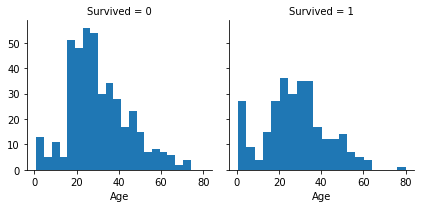

In [14]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## 关联数字和序数特征
我们可以使用单个图，结合多个特征来识别相关性。这可以通过具有数字值属性的数字特征和分类特征来完成。

### 观察
- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

### 结论
- Consider Pclass for model training.

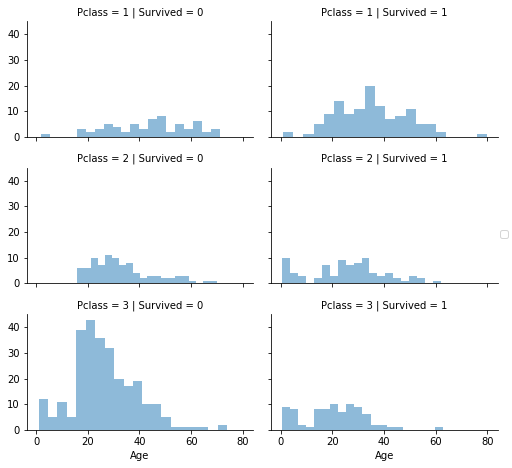

In [15]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## 关联分类特征
现在我们可以将分类特征与我们的解决目标相关联。

### 观察
- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

### 结论
- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

/home/public/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/public/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


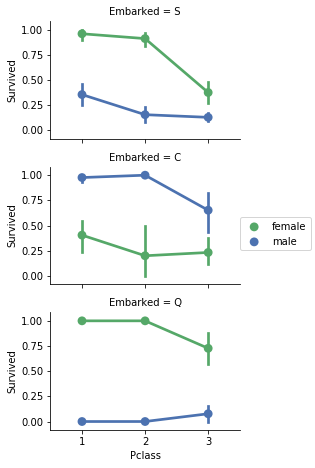

In [16]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## 关联可分类和数字特征
我们也可能希望关联分类特征（非数字值）和数字特征。我们可以考虑将 Embarked（分类非数字），Sex（分类非数字），Fare（数字连续）与Survived （分类数字）相关联。

### 观察
- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

### 结论
- Consider banding Fare feature.

/home/public/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


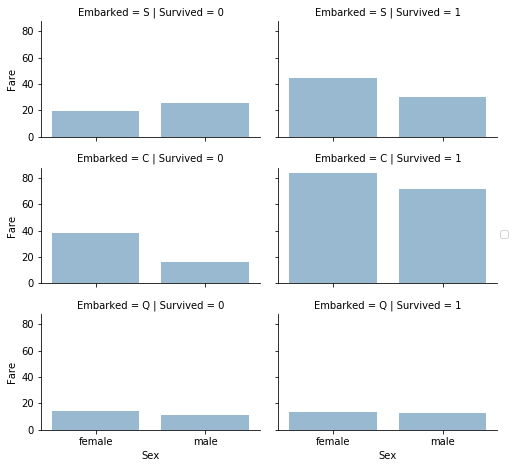

In [17]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# 整理数据(Wrangle Data)
我们收集了关于我们的数据集和解决方案要求的几个假设和决定。到目前为止，我们不必为了达到这些目的而改变单个特征或值。让我们现在执行我们的决定和假设来纠正，创建和完成目标。

## 通过删除特征修正
这是一个很好的开始任务去执行。通过删除特征，我们处理的数据点更少。加快我们的notebook，并简化分析。

给予我们的假设和结论，我们想要删除 Cabin (correcting #2) 和 Ticket (correcting #1) 特征。

请注意，在适用的情况下，我们一起对训练和测试数据集执行操作，以保持一致。

In [18]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]
print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


## 从现有特征中提取新的特征
在删除Name和PassengerId特征之前，我们想要分析如果Name特征可以被设计来提取Title特征，并且测试title和survival的关联关系。

在下面的代码中，使用正则表达式提取Title特征。正则模式`(\w+\.)`匹配Name特征中，以`.`结尾的第一个单词。`expand=False`标志返回一个 `DataFrame`。

### 观察
当我们绘制标题，年龄和生存时，我们注意到以下观察。
- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
- Survival among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

### 结论
- We decide to retain the new Title feature for model training.

In [19]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


我们可以用更常见的名称替换许多标题，或将它们归类为Rare。

In [20]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


我们可以转换分类标题为序数。

In [21]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


现在我们可以从训练和测试数据集中安全地删除 Name 特征。在训练集中我们也不许要 PassengerId 特征.

In [22]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### 变换可分类特征
现在我们可以将包含字符串的特征转换为数值类型。这是大多数模型算法所要求的。这样做也将帮助我们实现功能完成目标。

变换 Sex 特征为一个新的特征 Gender，其中`female=1 and male=0`。

In [23]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## 补全连续数值特征
现在我们开始估计并补全缺失值和空值。先来完成Age特征。

我们可以考虑三种方法来补全数值连续特征。
- A simple way is to generate random numbers between mean and standard deviation.
- More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...
- Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

方法1和3将在我们的模型中引入随机噪声。多次执行的结果可能会有所不同。我们更倾向于方法2。

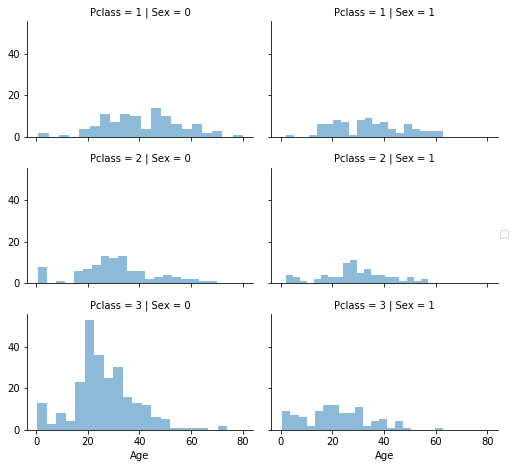

In [24]:
# 补全数值连续特征
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [25]:
guess_age = np.zeros((2, 3))
guess_age

array([[0., 0., 0.],
       [0., 0., 0.]])

现在我们遍历Sex（0或1）和Pclass（1，2，3）来计算6种组合的Age的猜测值。

In [26]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            # print(guess_df.median())
            guess_age[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_age[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


让我们创建 Age bands，判断和Survived的关系。

In [27]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


让我们用基于这些band的序数替换Age。

In [28]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


我们不能移除 AgeBand 特征。

In [29]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


## 组合已有的特征创建新特征
我们可以组合 Parch 和 SibSp 创建新的特征 FamilySize。这使得我们可以删除 Parch 和 SibSp 特征。

In [30]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


我们可以创建另一个叫 IsAlone 的特征。

In [31]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


让我们移除 Parch，SibSp 和 FamilySize 特征以支持IsAlone。

In [32]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


我们还可以创建一个结合Pclass和Age的人工特征。

In [33]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


## 补全一个分类特征
Embarked 特征根据登船口取值S, Q, C。我们的训练数据有两个缺失值，使用众数填充。

In [34]:
freq_port = train_df.Embarked.dropna().mode()[0]
print(freq_port)

S


In [35]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


## 转换分类特征为数字类型
现在，我们可以通过创建数字的Port特征，转换EmbarkedFill特征。

In [36]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


## 快速补全和转换一个数字特征
我们可以补全测试集中Fare特征的单一缺失值，使用mode获取该特征出现最频繁的值。

In [37]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


我们不能够创建FareBand属性。

In [38]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


基于FareBand，转换Fare属性为序数值。

In [39]:
for dataset in combine:
    dataset.loc[dataset['Fare'] >= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7,0,1,0,3
1,1,1,1,2,0,1,3,0,2
2,1,3,1,1,0,0,2,1,3
3,1,1,1,2,0,0,3,0,2
4,0,3,0,2,0,0,1,1,6
5,0,3,0,1,0,2,1,1,3
6,0,1,0,3,0,0,1,1,3
7,0,3,0,0,0,0,4,0,0
8,1,3,1,1,0,0,3,0,3
9,1,2,1,0,0,1,3,0,0


In [40]:
# 测试集
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7,2,1,1,6
1,893,3,1,2,7,0,3,0,6
2,894,2,0,3,0,2,1,1,6
3,895,3,0,1,0,0,1,1,3
4,896,3,1,1,0,0,3,0,3
5,897,3,0,0,0,0,1,1,0
6,898,3,1,1,7,2,2,1,3
7,899,2,0,1,0,0,1,0,2
8,900,3,1,1,7,1,3,1,3
9,901,3,0,1,0,0,1,0,3


# 模型，预测，解决
现在准备训练一个模型并做出预测。有60多种预测模型算法可供选择。我们必须理解问题的类型和解决方案要求，缩小我们可以评估的模型。

我们的问题是一个分类和回归问题。我们想确定输出(Survived)与其他变量或特性(Gender, Age, Port...)之间的关系。我们需要使用一类叫做监督学习的机器学习方法。

使用这两个标准，监督学习和分类回归，可以缩小我们的选择：
- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forrest
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [41]:
X_train = train_df.drop('Survived', axis=1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

在工作流的一开始，运行Logistic Regression是非常有用的。Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. 

In [42]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.58

我们可以使用逻辑回归验证我们的假设、创建特征的决定、补全目标。可以通过计算在决策函数中计算属性系数。

正系数增加结果的`log-odds`；负系数减小结果的`log-odds`。

- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.
- This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
- So is Title as second highest positive correlation.

In [43]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.198961
5,Title,0.394718
2,Age,0.277426
4,Embarked,0.257033
6,IsAlone,0.189943
3,Fare,0.013919
7,Age*Class,-0.302198
0,Pclass,-0.720824


Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier.

Note that the model generates a confidence score which is higher than Logistics Regression model.

In [44]:
# 支持向量机

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.94

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. 

KNN confidence score is better than Logistics Regression but worse than SVM.

In [45]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

81.48

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. 

The model generated confidence score is the lowest among the models evaluated so far.

In [46]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

71.83

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

In [47]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/home/public/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


75.42

In [48]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

78.68

In [49]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/home/public/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


76.77

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

The model confidence score is the highest among models evaluated so far.

In [50]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.19

The next model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. 

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [51]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.19

# Model evaluation
We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set.

In [52]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,85.19
8,Decision Tree,85.19
0,Support Vector Machines,82.94
1,KNN,81.48
2,Logistic Regression,80.58
7,Linear SVC,78.68
6,Stochastic Gradient Decent,76.77
5,Perceptron,75.42
4,Naive Bayes,71.83


In [53]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)

Our submission to the competition site Kaggle results in scoring 3,883 of 6,082 competition entries. This result is indicative while the competition is running. This result only accounts for part of the submission dataset. Not bad for our first attempt. Any suggestions to improve our score are most welcome.